# MESA session 4: solution notebook


In [36]:
import sys, os
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt 
import astropy.units as u
import astropy.constants as const


***
# 1. X-ray binaries

## •) 

We see the master `inlist` points to `inlist_project` for most controls, but to inlist1 for the plotting.

`inlist_project` contains some general binary mass transfer settings and sets the masses of the donor (star 1) and accretor/companion (star 2). 
 
 The **donor** is described in inlists with "1", i.e., `inlist1` and `inlist1_spec` 

Inlists with a "2" describe the **accretor** :
`inlist2` points to  `inlist2_spec` 

Becasue in `inlist_project`
'   evolve_both_stars = .false.', only star 1 (the donor) will be evolved (the other is treated as a point mass)

There is also `inlist_massive_defaults`, which details some general settings for massive stars.

## a) HR diagram

Let's reuse our HR diagram plotter from last time: 

In [4]:
# Define a HR diagram plotting function that we can re-use
def HR_diagram(histoy_list, xlim=(None, None), ylim=(None, None),
               VMIN=-3, VMAX=0, cmap_name = 'rainbow', 
               colour_by='center_h1', colour_label='kleur',
               save_loc='./plots/'):
    """
    Plot a HR diagram from a list of mesa history data files.

    """

    fig, ax = plt.subplots(figsize=(10, 8))

    # Function to calc R from stefan-boltzmann law
    def Radius(Teff, L):
        Teff = Teff * u.K
        L = (L * u.Lsun).to(u.W)
        R = (L / (4 * np.pi * const.sigma_sb * Teff**4))**0.5
        return R.to(u.Rsun).value

    # --- Radius contour grid ---
    Teffs = np.linspace(3.5, 8, 100)
    Ls = np.linspace(0.5, 5.0, 100)
    Teffs_grid, Ls_grid = np.meshgrid(Teffs, Ls)
    Radius_grid = Radius(10**Teffs_grid, 10**Ls_grid)

    CS = ax.contour(Teffs_grid, Ls_grid, Radius_grid,
                    levels=[1, 10, 100, 1e3, 1e4],
                    colors='#969696', linestyles='dashed')
    ax.clabel(CS, inline=1, inline_spacing=-5, fontsize=15)
            #   manual=[(4.5, 3.2), (3.9, 3.2), (3.5, 3.2), (2.5, 3.2), (1.5, 3.1)])

    # --- Plot each star ---     
    for i, hist in enumerate(histoy_list):
        # find where to start the center h drops below 0.69
        start = np.flatnonzero(np.asarray(hist.center_h1) < 0.69)[0] if (np.asarray(hist.center_h1) < 0.69).any() else 0

        # get relevant data from the start of MS to 
        log_Teff = hist.log_Teff[start:] 
        log_L    = hist.log_L[start:] 
        C        = np.asarray(getattr(hist, colour_by))[start:]

        scat = ax.scatter(log_Teff, log_L, c=C, cmap = cmap_name, vmin=VMIN, vmax=VMAX, s=8)

        # Annotate the mass of the star at the start of the MS
        ax.scatter(log_Teff[0], log_L[0], marker='*', s=50)
        ax.text(log_Teff[0],  log_L[0] , f"${np.round(hist.star_mass[0], 1)}$"+"M$_{\odot}$",
                 ha='right', va='top', fontsize = 15) #log_Teff

    cb = plt.colorbar(scat, ax=ax)
    cb.set_label(colour_label if colour_label else (f"{colour_by} / L" if Lfrac else colour_by), fontsize=20)

    # -- Plot values -- 
    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)', fontsize=25)
    ax.set_ylabel('log$_{10}$(L/L$_{\\odot}$)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if xlim != (None, None): ax.set_xlim(xlim)
    if ylim != (None, None): ax.set_ylim(ylim)
    ax.invert_xaxis()
    fig.tight_layout()

    os.makedirs(save_loc, exist_ok=True)
    out = os.path.join(save_loc, f"HR_{colour_by}.png")
    plt.savefig(out, bbox_inches='tight')
    plt.show()
    return 


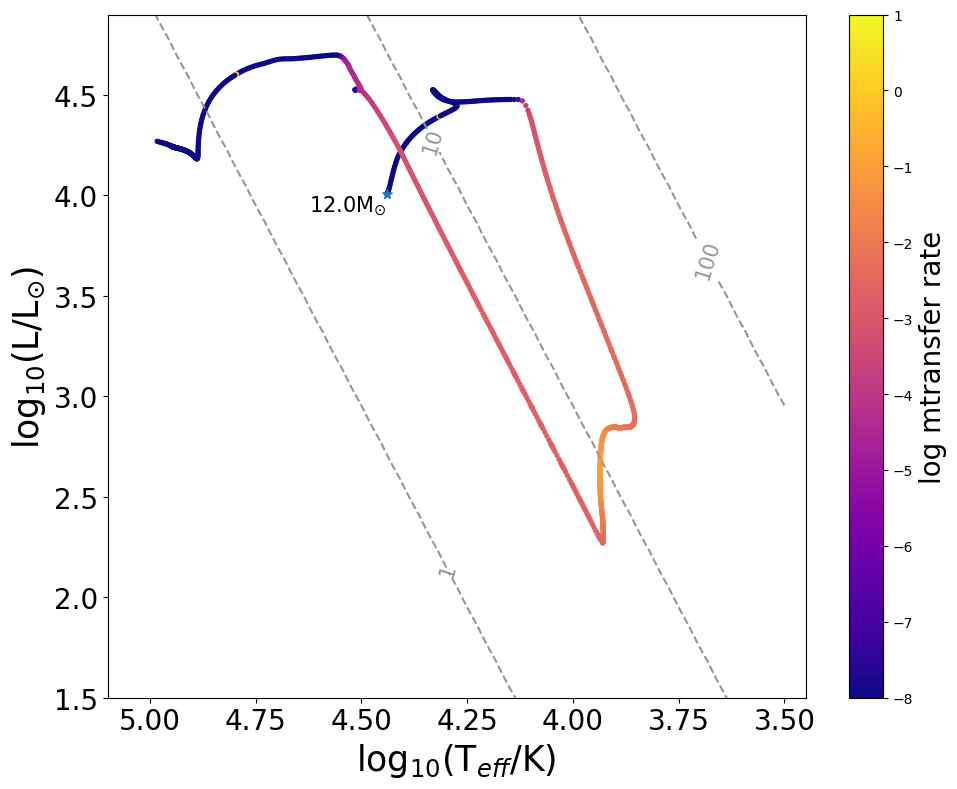

In [11]:
# Load your computed models
donor_history = mr.MesaData('./data/session4_work/LOGS1/history.data')

HR_diagram([donor_history],
           xlim=(3.45, 5.1), ylim=(1.5, 4.9),
           VMIN=-8, VMAX=1, cmap_name = 'plasma',
           colour_by='lg_mtransfer_rate', colour_label='log mtransfer rate')


We see that the star starts RLOF post while on the Hertszprung gap (case B mass transfer). 
From that point onwards it is very different from 'normal' single stellar evolution. 
The star plummets to low luminosities, this is caused by the strong thermal disequilibrium of the primary: a radiative donor star shrinks in response to mass loss and has to re-expand to regain thermal equilibrium. This requires the absorption of gravitational energy, so that the surface luminosity during thermal-timescale mass transfer is (much) smaller than the nuclear luminosity provided by the H-burning shell.


The star stops mass transferring when essentially the whole envelope is lost, when the mass transfer nears the core, it no longer responds to mass loss as a radiative envelope. In the HR diagram, this occurs at the hook at high luminosity, after which the star shrinks. 

The star has now become very luminous and hot post mass transfer: it is a stripped He star!



# b) mass transfer rate:

10336.375266350873 m 1.4857517991017497e-05 solRad


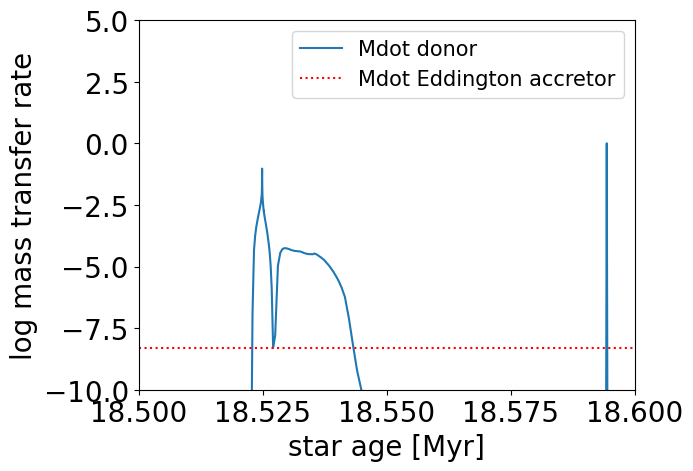

In [22]:
# Mdot donor
plt.plot(donor_history.age/1e6, donor_history.lg_mtransfer_rate, label = 'Mdot donor')

# Assuming Racc is the schwarschild radius
Mbh = 3.5*u.Msun
Mbh_kg = Mbh.to(u.kg)
Rsch = 2 * const.G * Mbh_kg / const.c**2
Rsch_msun = Rsch.to(u.Rsun)
print(Rsch, Rsch_msun)
Mdot_edd = 3.3 * 10**-4 * Rsch_msun.value

plt.axhline(np.log10(Mdot_edd), label = 'Mdot Eddington accretor', c= 'r', ls = ":")

plt.xlim(18.5,18.6)
plt.ylim(-10,5)
plt.xlabel('star age [Myr]',fontsize = 20)
plt.ylabel('log mass transfer rate', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize = 15)

plt.show()

The donors mass transfer rate much exceeds the eddington accretion rate. We don't think the black hole will accrete much of this, because it is accretion rate was set to be Eddington limited. 

In [29]:
# Read the binary history data 
binary_history = mr.MesaData('./data/session4_work/binary_history.data')

# How much mass did the donor star lose? 
# What fraction of this mass is accreted by the black hole and how much is lost from the system?
dma = binary_history.star_2_mass[-1] - binary_history.star_2_mass[0]
dmd = binary_history.star_1_mass[-1] - binary_history.star_1_mass[0]
print(f"Delta accretor mass {np.round(dma,3)} Msun")
print(f"Delta donor mass {np.round(dmd,3)} Msun")
print(f"Fractional accretion {np.round(dma / abs(dmd) *100, 2)} %")


Delta accretor mass 0.004 Msun
Delta donor mass -8.611 Msun
Fractional accretion 0.04 %


We see that while the donor has lost 8 solar masses, the accretor has indeed barely accreted anything. 

## C) Binary Black hole properties

In [31]:
Mbh1 = binary_history.star_1_mass[-1]
Mbh2 = binary_history.star_2_mass[-1]
print(f" Donor mass at end of simulation {Mbh1}" )

# Final separation
# binary_history.period_days[-1]
afinal =  binary_history.binary_separation[-1] # in Rsun
print(f" Final separation {afinal} Rsun" )

 Donor mass at end of simulation 3.389344512779557
 Final separation 15.789148548727947 Rsun


we have a BBH system with the accretor still being about 3.5Msun, and the donor now being very similar in mass about 3.4Msun.

They are in an orbital period of ~16 Rsun

In [32]:
def tau_merge(a_Rsun, M1_Msun, M2_Msun):
    """
    tau = 1.503e8 yr * [1/(q(1+q))] * (a/Rsun)^4 * (M1/Msun)^(-3)

    ----------
    a  : separation assumed in Rsun
    M1 : primary mass assumed in in Msun
    """
    # Note that the actual peters formula is symmetric in mass, so it doesnt matter wchich is BH1 or 2
    q = M2_Msun/M1_Msun

    tau_yr = 1.503e8 * (1.0 / (q * (1.0 + q))) * (a_Rsun**4) * (M1_Msun**-3)
    return tau_yr 

print(f"Merger timescale = {tau_merge(afinal, Mbh2, Mbh1)*1e-9} Gyr ")


Merger timescale = 114.11613329690832 Gyr 


This is longer than the age of the universe.  LVK will never see this! 

# 2. Simultanious evolution of two massive stars

## •) 

We see that the more massive star runs out of hydrogen first, which is what we expect since the nuclear timescale scales with mass to 
$$
\tau_{nuc} \propto 10^{10} \frac{M}{M_{\odot}} \frac{L_{\odot}}{L} \propto M^{-2.8}
$$
given the mass luminosity relation $L\propto M^{3.8}$.

The surface abundance doesn't change for most of the evolution since the envelope is still made of unprocecced material. Only when the donor star is fully stripped will its surface abundance change (become more He enriched).

In [40]:
binary_history.bulk_names

('model_number',
 'age',
 'period_days',
 'binary_separation',
 'v_orb_1',
 'v_orb_2',
 'rl_1',
 'rl_2',
 'rl_relative_overflow_1',
 'rl_relative_overflow_2',
 'star_1_mass',
 'star_2_mass',
 'lg_mtransfer_rate',
 'lg_mstar_dot_1',
 'lg_mstar_dot_2',
 'lg_system_mdot_1',
 'lg_system_mdot_2',
 'lg_wind_mdot_1',
 'lg_wind_mdot_2',
 'eff_xfer_fraction',
 'J_orb',
 'Jdot',
 'jdot_mb',
 'jdot_gr',
 'jdot_ml',
 'jdot_ls',
 'jdot_missing_wind',
 'extra_jdot',
 'donor_index',
 'point_mass_index')

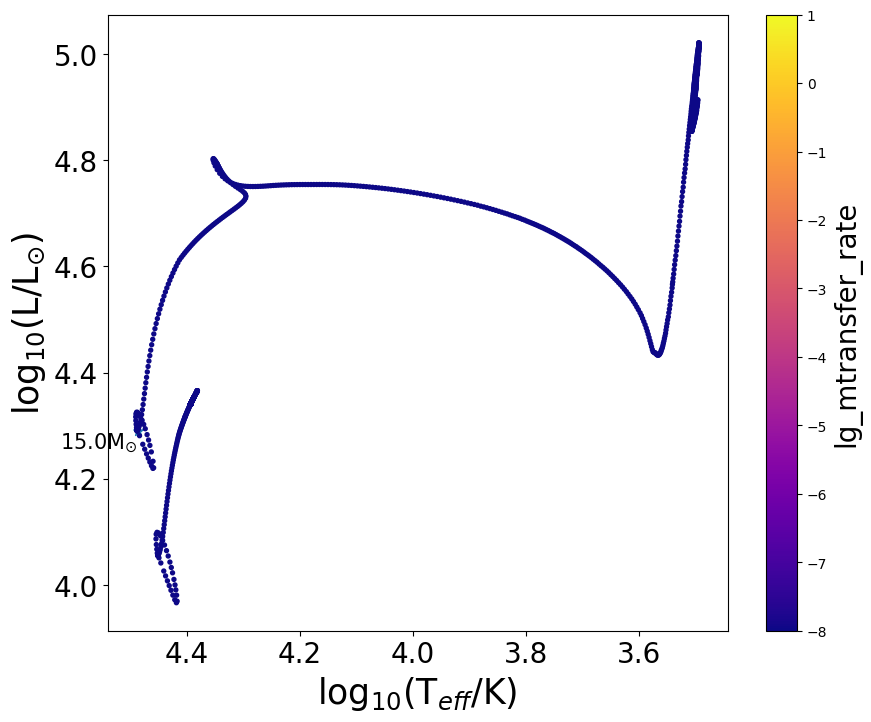

In [79]:
donor_history = mr.MesaData('./data/session4_work_2/LOGS1/history.data')
accretor_history = mr.MesaData('./data/session4_work_2/LOGS2/history.data')

fig, ax = plt.subplots(figsize=(10, 8))

# Annotate the mass of the star at the start of the MS
ax.scatter(donor_history.log_Teff[0], donor_history.log_L[0], marker='*', s=50)
ax.text(donor_history.log_Teff[0],  donor_history.log_L[0] , f"${np.round(donor_history.star_mass[0], 1)}$"+"M$_{\odot}$",
            ha='right', va='top', fontsize = 15) #log_Teff

VMIN=-8
VMAX=1
cmap_name = 'plasma'

# Accretor
scat = ax.scatter(accretor_history.log_Teff, accretor_history.log_L, 
c=accretor_history.lg_mtransfer_rate, cmap = cmap_name, vmin=VMIN, vmax=VMAX, s=8)

#Donor
scat = ax.scatter(donor_history.log_Teff, donor_history.log_L, c= donor_history.lg_mtransfer_rate, cmap = cmap_name, vmin=VMIN, vmax=VMAX, s=8  )

cb = plt.colorbar(scat, ax=ax)
cb.set_label('lg_mtransfer_rate', fontsize=20)

# -- Plot values -- 
ax.set_xlabel('log$_{10}$(T$_{eff}$/K)', fontsize=25)
ax.set_ylabel('log$_{10}$(L/L$_{\\odot}$)', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

ax.invert_xaxis()

plt.show()


## a) mass transfer efficiency 

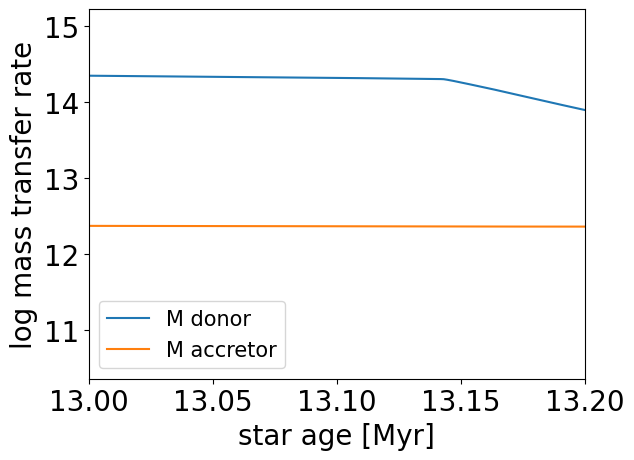

Delta accretor mass -0.15546281926174466
Delta donor mass -4.4149904095900006
Fractional accretion -0.03521249308357654


In [78]:
binary_history = mr.MesaData('./data/session4_work_2_1/binary_history.data')

# Donor mass
plt.plot(binary_history.age/1e6, binary_history.star_1_mass, label = 'M donor')
plt.plot(binary_history.age/1e6, binary_history.star_2_mass, label = 'M accretor')

plt.xlim(13.0,13.2)
# plt.ylim(0,12)
plt.xlabel('star age [Myr]',fontsize = 20)
plt.ylabel('log mass transfer rate', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize = 15)
plt.show()

dma = binary_history.star_2_mass[-1] - binary_history.star_2_mass[0]
dmd = binary_history.star_1_mass[-1] - binary_history.star_1_mass[0]
print(f"Delta accretor mass {dma}")
print(f"Delta donor mass {dmd}")
print(f"Fractional accretion {dma / abs(dmd)}")


We see that the accretor star has accreted about 43%

## b) rejuvination

data/session4_work_2/LOGS1 ['data/session4_work_2/LOGS1']
Reading profile data
Reading history data
Constructing mixing regions
there are 10 mixing zones
data/session4_work_2/LOGS2 ['data/session4_work_2/LOGS2']
Reading profile data
Reading history data
Constructing mixing regions
there are 10 mixing zones


Kipp_Plot(contour_plot=<matplotlib.contour.QuadContourSet object at 0x12eb8fd00>, histories=[<mesa_data.mesa_data object at 0x11f5d1c10>], xlims=(1.0, 841.0))

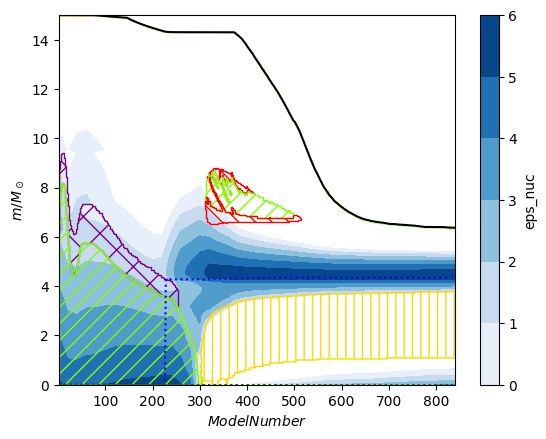

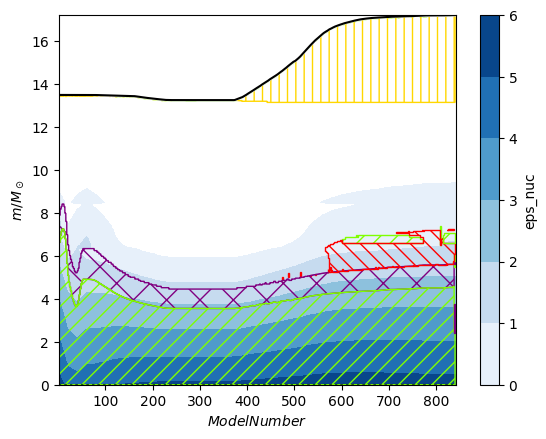

In [37]:

sys.path.append(os.path.expanduser("~/Programs/mkipp"))

import mkipp
import kipp_data
import mesa_data

# Donor Kippenhahn
mkipp.kipp_plot(mkipp.Kipp_Args(logs_dirs = ['data/session4_work_2/LOGS1'], save_filename = "plots/Kippenhahn.png",))

# Accretor Kippenhahn
mkipp.kipp_plot(mkipp.Kipp_Args(logs_dirs = ['data/session4_work_2/LOGS2'], save_filename = "plots/Kippenhahn.png",))


The convective core of the secondary grows a bit due to accretion. 
There will be more fresh hydrogen mixed into the accretors core. 

This is indeed rejuvination: the star now has more fresh fuel available and will be able to live longer than if it hadn't accreted. 

This process is indeed a possible solution to 'blue stragglers', i.e. stars that are to hot for the turn-off of their cluster population (based on simple single-star evolution, you would have expected these stars to have already evolved off the main-sequence.)
 